In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import math

#한글 깨짐 방지 코드
from matplotlib import rc, style, font_manager
font_name = font_manager.FontProperties(fname="C:/windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
style.use('ggplot')

test = pd.read_csv("D:/전력예측/전처리test.csv", encoding='euc-kr')
train = pd.read_csv("D:/전력예측/전처리train.csv", encoding='euc-kr')

In [63]:
en = train['전력사용량']

### 군집화 과정 

- 각 건물번호의 박스플롯을 확인하고, 건물번호 간 유사한 모양을 띄고 있는 그룹이 있어 각 건물의 기초통계량(평균,최댓값, 최솟값, 표준편차)을 이용해 군집화 시도 -> 시간대, 요일별 히트맵을 봤을 때 유의미한 구분 x
- 따라서 각 건물의 요일별 평균, 시간대별 평균값을 column으로 생성하여 군집화 시도

In [2]:
# 그냥 표준화 작업이 아닌, 건물별 전력사용량을 기준으로 표준화해야함

for i in range(1, 61):
    mean_ = train.loc[train.건물번호 == i].전력사용량.mean()
    std_ = train.loc[train.건물번호 == i].전력사용량.std()
    train.loc[train.건물번호 == i, '전력사용량'] = ((train.loc[train.건물번호 == i, '전력사용량']) - mean_) / std_

In [3]:
# 요일에 따른 평균

weekday_mean = (
    train.groupby(['건물번호', '요일'])['전력사용량'].mean()
    .reset_index()
    .pivot('건물번호', '요일', '전력사용량')
    .reset_index()
)

In [4]:
# 시간에 따른 평균

hour_mean = (
    train.groupby(['건물번호', '시간'])['전력사용량'].mean()
    .reset_index()
    .pivot('건물번호', '시간', '전력사용량')
    .reset_index()
    .drop('건물번호', axis=1)
)

In [5]:
cl_df = pd.concat([weekday_mean, hour_mean], axis=1)

In [28]:
cl_df.head()

,건물번호,금,목,수,월,일,토,화,0,1,...,14,15,16,17,18,19,20,21,22,23
0,1,0.207538,0.136859,0.065127,-0.013265,-0.124387,0.004373,-0.275141,-0.022265,-0.200351,...,0.438781,0.486945,0.490691,0.413908,0.283379,0.294580,0.227571,0.228683,0.234710,0.079624
1,2,0.269986,0.304359,0.266059,0.219825,-0.711788,-0.613713,0.246954,-0.843264,-0.871100,...,0.927692,0.887512,0.828227,0.656724,0.131663,-0.303718,-0.510565,-0.631740,-0.747649,-0.802314
2,3,0.176369,0.198316,0.155745,-0.001191,-0.354502,-0.176871,0.002234,0.068953,0.104412,...,-0.179592,0.098628,0.158603,0.145217,-0.076369,-0.251865,-0.282285,-0.342865,-0.345398,0.297465
3,4,0.121706,0.060515,-0.071670,-0.156680,0.005172,0.223918,-0.169906,-0.738844,-0.803466,...,1.145659,1.201668,1.142114,0.907742,0.348254,0.022042,-0.321251,-0.510391,-0.682189,-0.649852
4,5,0.304741,-0.070623,-0.040268,0.014861,-0.258837,0.074887,-0.025999,0.581476,0.466763,...,-0.168711,-0.120386,-0.313461,-0.438549,-0.915961,0.234951,0.996338,0.953813,0.837413,0.710313


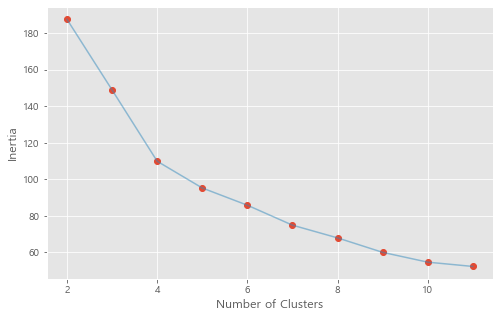

In [6]:
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# elbow method를 통해 군집의 개수 결정
def change_n_clusters(n_clusters, data):
    
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)
        
    plt.figure(1 , figsize = (8, 5))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

change_n_clusters([2,3,4,5,6,7,8,9,10,11],  cl_df.iloc[:,1:])

In [7]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

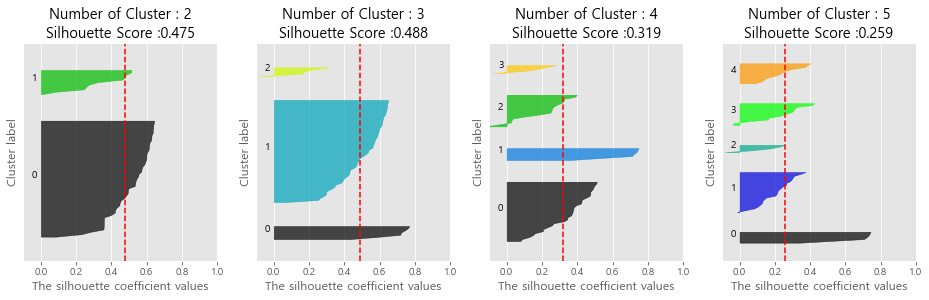

In [49]:
visualize_silhouette([ 2, 3, 4, 5], cl_df.iloc[:,1:])

#### 엘보우 기법을 사용했을 때, 적절한 군집은 3개 혹은 4개
#### 실루엣 계수를 사용했을 때, 3개 군집이 가장 적절해보이지만, 실제 히트맵을 그렸을 때, 4개일 때가 각각 대표성을 잘 띈다고 판단

In [8]:
from sklearn.decomposition import PCA

kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300,random_state=0)
kmeans.fit(cl_df.iloc[:, 1:])
KMeans(n_clusters=3, random_state=0)

cl_df['클러스터'] = kmeans.labels_
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(cl_df.iloc[:,1:])

cl_df['pca_x'] = pca_transformed[:,0]
cl_df['pca_y'] = pca_transformed[:,1]

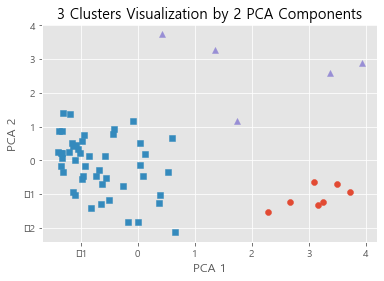

In [9]:
# 군집 값이 0, 1, 2인 경우마다 별도의 인덱스로 추출
marker0_ind = cl_df[cl_df['클러스터']==0].index
marker1_ind = cl_df[cl_df['클러스터']==1].index
marker2_ind = cl_df[cl_df['클러스터']==2].index

# 군집 값 0, 1, 2에 해당하는 인덱스로 각 군집 레벨의 pca_x, pca_y 값 추출. o, s, ^ 로 마커 표시
plt.scatter(x=cl_df.loc[marker0_ind, 'pca_x'], y=cl_df.loc[marker0_ind, 'pca_y'], marker='o')
plt.scatter(x=cl_df.loc[marker1_ind, 'pca_x'], y=cl_df.loc[marker1_ind, 'pca_y'], marker='s')
plt.scatter(x=cl_df.loc[marker2_ind, 'pca_x'], y=cl_df.loc[marker2_ind, 'pca_y'], marker='^')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('3 Clusters Visualization by 2 PCA Components')
plt.show()

In [10]:
def merge_df(cl_df, train):
    
    cl_df = cl_df[['건물번호','클러스터']]
    merged_df = pd.merge(cl_df, train, on='건물번호')
    
    return merged_df

train = merge_df(cl_df,train)
train.head()

,건물번호,클러스터,date_time,전력사용량,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유,연도,월,일,시간,요일,주말,체감온도,불쾌지수
0,1,2,2020-06-01 00:00:00,-2.795969,17.6,2.5,92.0,0.8,0.0,0.0,0.0,2020,6,1,0,월,0,18.973374,347.964
1,1,2,2020-06-01 01:00:00,-3.129259,17.7,2.9,91.0,0.3,0.0,0.0,0.0,2020,6,1,1,월,0,18.960338,353.930
2,1,2,2020-06-01 02:00:00,-3.348135,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2020,6,1,2,월,0,18.658598,335.750
3,1,2,2020-06-01 03:00:00,-3.795838,17.1,3.2,91.0,0.0,0.0,0.0,0.0,2020,6,1,3,월,0,18.218957,299.390
4,1,2,2020-06-01 04:00:00,-3.835633,17.0,3.3,92.0,0.0,0.0,0.0,0.0,2020,6,1,4,월,0,18.081523,292.830


In [11]:
train['클러스터'] = train['클러스터'].replace({0: 1, 1: 2, 2: 3, 3: 4})

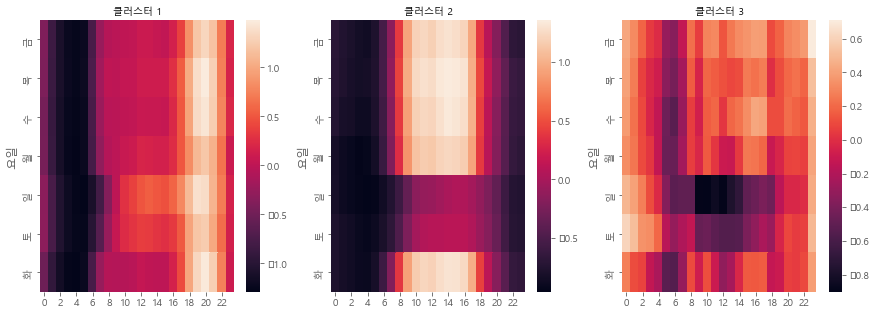

In [144]:
plt.figure(figsize=(20,5))

for num in train['클러스터'].unique():
    df = train[train.클러스터 == num]
    df = df.groupby(['요일', '시간'])['전력사용량'].mean().reset_index().pivot('요일', '시간', '전력사용량')
    plt.subplot(1, 4, num)
    sns.heatmap(df)
    plt.title(f'클러스터 {num}', fontsize=10)
    plt.xlabel('')

- 1번 군집: 18~22시까지 사용량이 높음. 또한, 주말에도 사용량이 높은 군집
- 2번 군집: 주말에 사용량이 거의 없는 건물. 대신, 다른 요일의 8~16시까지 아주 높은 사용량을 가짐
- 3번 군집: 모든 시간대에 걸쳐 밸런스있게 포진

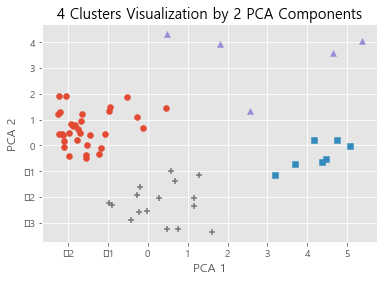

In [54]:
from sklearn.decomposition import PCA

kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300,random_state=0)
kmeans.fit(cl_df.iloc[:, 1:])
KMeans(n_clusters=4, random_state=0)

cl_df['클러스터'] = kmeans.labels_
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(cl_df.iloc[:,1:])

cl_df['pca_x'] = pca_transformed[:,0]
cl_df['pca_y'] = pca_transformed[:,1]

# 군집 값이 0, 1, 2인 경우마다 별도의 인덱스로 추출
marker0_ind = cl_df[cl_df['클러스터']==0].index
marker1_ind = cl_df[cl_df['클러스터']==1].index
marker2_ind = cl_df[cl_df['클러스터']==2].index
marker3_ind = cl_df[cl_df['클러스터']==3].index


# 군집 값 0, 1, 2에 해당하는 인덱스로 각 군집 레벨의 pca_x, pca_y 값 추출. o, s, ^ 로 마커 표시
plt.scatter(x=cl_df.loc[marker0_ind, 'pca_x'], y=cl_df.loc[marker0_ind, 'pca_y'], marker='o')
plt.scatter(x=cl_df.loc[marker1_ind, 'pca_x'], y=cl_df.loc[marker1_ind, 'pca_y'], marker='s')
plt.scatter(x=cl_df.loc[marker2_ind, 'pca_x'], y=cl_df.loc[marker2_ind, 'pca_y'], marker='^')
plt.scatter(x=cl_df.loc[marker3_ind, 'pca_x'], y=cl_df.loc[marker3_ind, 'pca_y'], marker='+')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('4 Clusters Visualization by 2 PCA Components')
plt.show()

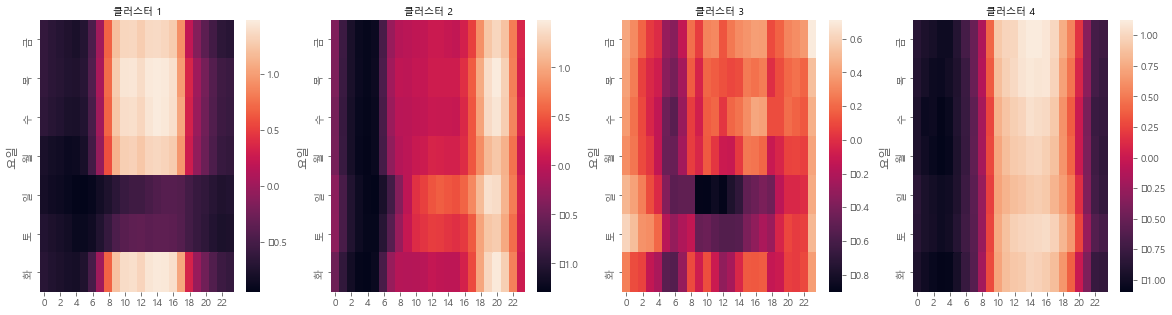

In [36]:
train1 = train.copy()

def merge_df(cl_df, train1):
    
    cl_df = cl_df[['건물번호','클러스터']]
    merged_df = pd.merge(cl_df, train1, on='건물번호')
    
    return merged_df

train1 = merge_df(cl_df,train1)
train1['클러스터_x'] = train1['클러스터_x'].replace({0: 1, 1: 2, 2: 3, 3: 4})

plt.figure(figsize=(20,5))

for num in train1['클러스터_x'].unique():
    df = train1[train1.클러스터_x == num]
    df = df.groupby(['요일', '시간'])['전력사용량'].mean().reset_index().pivot('요일', '시간', '전력사용량')
    plt.subplot(1, 4, num)
    sns.heatmap(df)
    plt.title(f'클러스터 {num}', fontsize=10)
    plt.xlabel('')

#### 실루엣 계수로 보나, 요일+시간대별 히트맵으로 보나 3개의 군집일 때가 4개일 때보다 잘 구분하는 것으로 보임 
#### 하지만 클러스터가 4일 때, 실루엣 계수표의 굵기가 밸런스있게 구성되어있음 
#### 3개일 때와 4개일 때 각각의 건물번호 히트맵을 살펴보자

### 군집이 3개일 때, 

In [12]:
train_1 = list(train.loc[train.클러스터 == 1].건물번호.unique())
train_2 = list(train.loc[train.클러스터 == 2].건물번호.unique())
train_3 = list(train.loc[train.클러스터 == 3].건물번호.unique())

(train.groupby(['클러스터'])['건물번호'].count().to_frame()/2040).T

클러스터,1,2,3
건물번호,7.0,48.0,5.0


In [13]:
train1 = train[train['클러스터']==1]

In [14]:
train1.groupby(['요일', '시간'])['전력사용량'].mean().reset_index().pivot('요일', '시간', '전력사용량')

시간,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
요일,,,,,,,,,,,,,,,,,,,,,
금,-0.400063,-0.855522,-1.101806,-1.222578,-1.256031,-1.202251,-0.760613,-0.236971,-0.048994,-0.012681,...,0.062614,0.028659,0.155689,0.380198,0.854773,1.208319,1.331000,1.188573,0.720691,0.205134
목,-0.406294,-0.860210,-1.102265,-1.212418,-1.251505,-1.192277,-0.731820,-0.183471,0.012465,0.008669,...,0.109295,0.117200,0.274799,0.536943,1.023992,1.380033,1.483602,1.282712,0.747102,0.173792
수,-0.464727,-0.884018,-1.122150,-1.233368,-1.265308,-1.214154,-0.767074,-0.222488,-0.028421,-0.016787,...,0.065545,0.059737,0.218991,0.504641,0.972696,1.356358,1.430968,1.260376,0.769043,0.207356
월,-0.453310,-0.875095,-1.116993,-1.235164,-1.269222,-1.216929,-0.788802,-0.287349,-0.064369,-0.010154,...,0.159725,0.157157,0.259081,0.505557,0.826439,1.124966,1.218341,1.062198,0.661736,0.094335
일,-0.322782,-0.762542,-1.040957,-1.189638,-1.257827,-1.284841,-1.093915,-0.801202,-0.365549,0.009668,...,0.507625,0.468650,0.576064,0.792089,1.134785,1.398276,1.365774,1.085007,0.724394,0.164625
토,-0.306996,-0.763383,-1.046874,-1.190758,-1.250154,-1.248135,-1.007154,-0.670367,-0.248164,0.056488,...,0.309804,0.275821,0.341863,0.523152,0.981068,1.207508,1.252114,1.009748,0.632226,0.150182
화,-0.518275,-0.926834,-1.157598,-1.262164,-1.288745,-1.221396,-0.764612,-0.246142,-0.052473,-0.057662,...,0.010365,0.001911,0.164082,0.443795,0.993377,1.333868,1.468702,1.277169,0.747256,0.105858


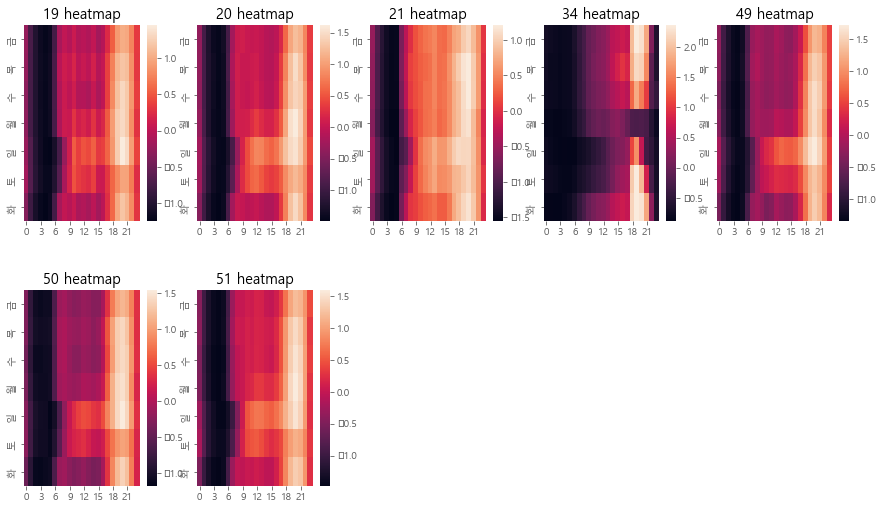

In [232]:
fig = plt.figure(figsize=(15, np.ceil(len(train_1)/5)*4))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35) #서브플롯 간 간격 조정

for i, n in enumerate(train_1):
    plt.subplot(np.ceil(len(train_1)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.건물번호 == n].groupby(['요일', '시간'])['전력사용량'].mean().unstack())
    plt.xlabel('')
    plt.ylabel('')

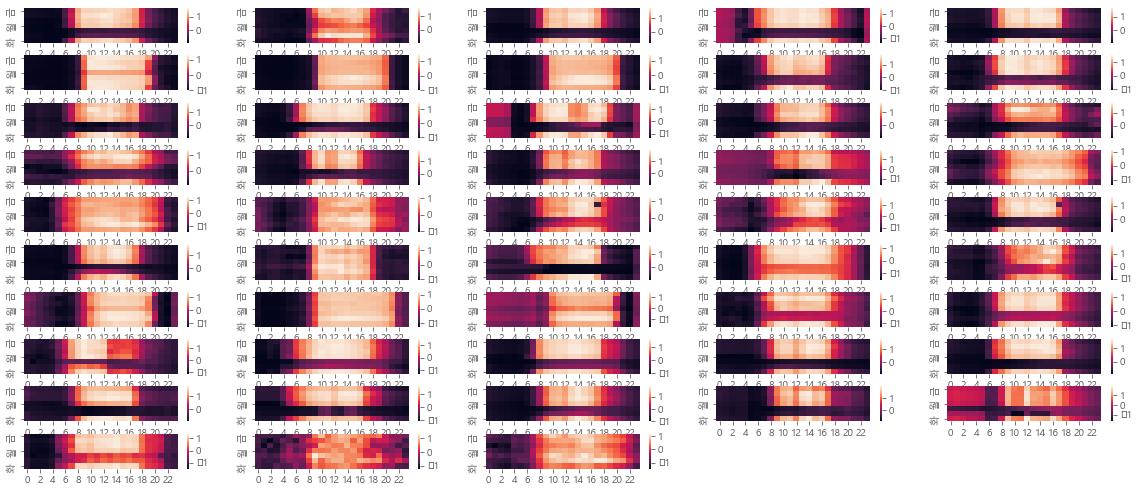

In [241]:
fig = plt.figure(figsize=(20, np.ceil(len(train_1)/6)*4))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35) #서브플롯 간 간격 조정

for i, n in enumerate(train_2):
    plt.subplot(np.ceil(len(train_2)/5), 5, i+1)
    #plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.건물번호 == n].groupby(['요일', '시간'])['전력사용량'].mean().unstack())
    plt.xlabel('')
    plt.ylabel('')

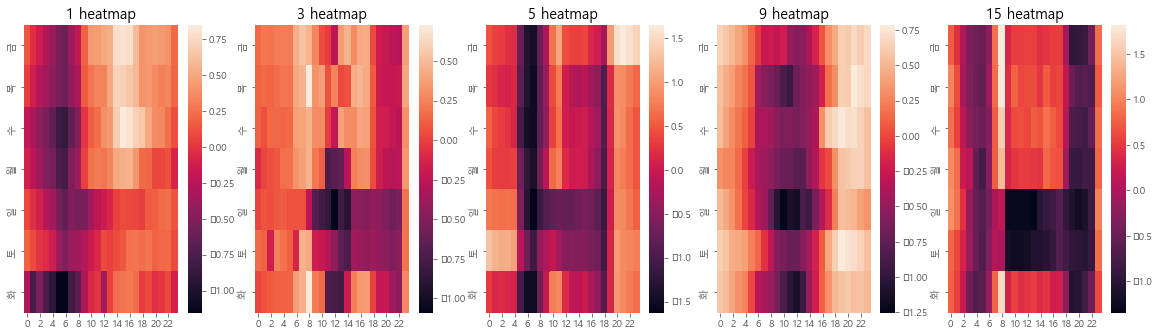

In [240]:
fig = plt.figure(figsize=(20,5))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35) #서브플롯 간 간격 조정

for i, n in enumerate(train_3):
    plt.subplot(np.ceil(len(train_3)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.건물번호 == n].groupby(['요일', '시간'])['전력사용량'].mean().unstack())
    plt.xlabel('')
    plt.ylabel('')

### 군집이 4개일 때, 

In [15]:
from sklearn.decomposition import PCA

kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300,random_state=0)
kmeans.fit(cl_df.iloc[:, 1:])
KMeans(n_clusters=4, random_state=0)

cl_df['클러스터4'] = kmeans.labels_
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(cl_df.iloc[:,1:])

cl_df['pca_x'] = pca_transformed[:,0]
cl_df['pca_y'] = pca_transformed[:,1]

In [16]:
def merge_df(cl_df, train):
    
    cl_df = cl_df[['건물번호','클러스터4']]
    merged_df = pd.merge(cl_df, train, on='건물번호')
    
    return merged_df

train = merge_df(cl_df,train)

In [17]:
train['클러스터4'] = train['클러스터4'].replace({0: 1, 1: 2, 2: 3, 3: 4})

In [18]:
t_1 = list(train.loc[train.클러스터4 == 1].건물번호.unique())
t_2 = list(train.loc[train.클러스터4 == 2].건물번호.unique())
t_3 = list(train.loc[train.클러스터4 == 3].건물번호.unique())
t_4 = list(train.loc[train.클러스터4 == 4].건물번호.unique())

(train.groupby(['클러스터4'])['건물번호'].count().to_frame()/2040).T

클러스터4,1,2,3,4
건물번호,32.0,7.0,5.0,16.0


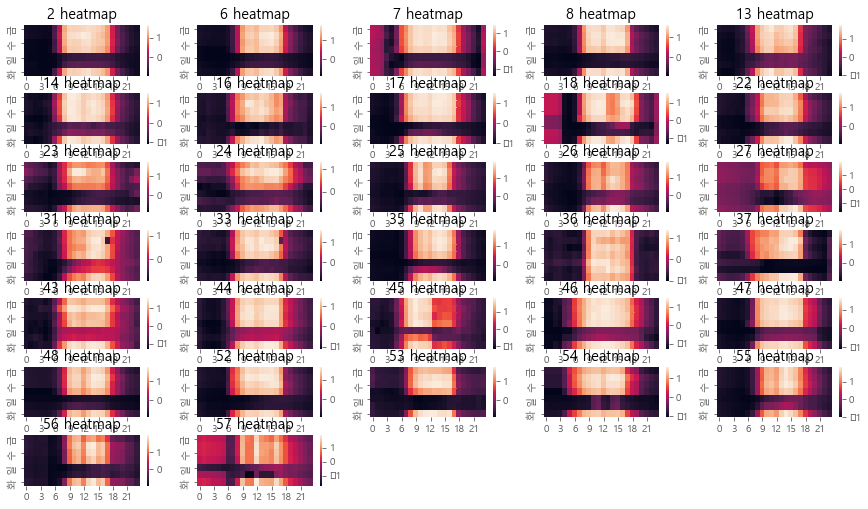

In [149]:
fig = plt.figure(figsize=(15, np.ceil(len(train_1)/5)*4))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35) #서브플롯 간 간격 조정

for i, n in enumerate(t_1):
    plt.subplot(np.ceil(len(t_1)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.건물번호 == n].groupby(['요일', '시간'])['전력사용량'].mean().unstack())
    plt.xlabel('')
    plt.ylabel('')

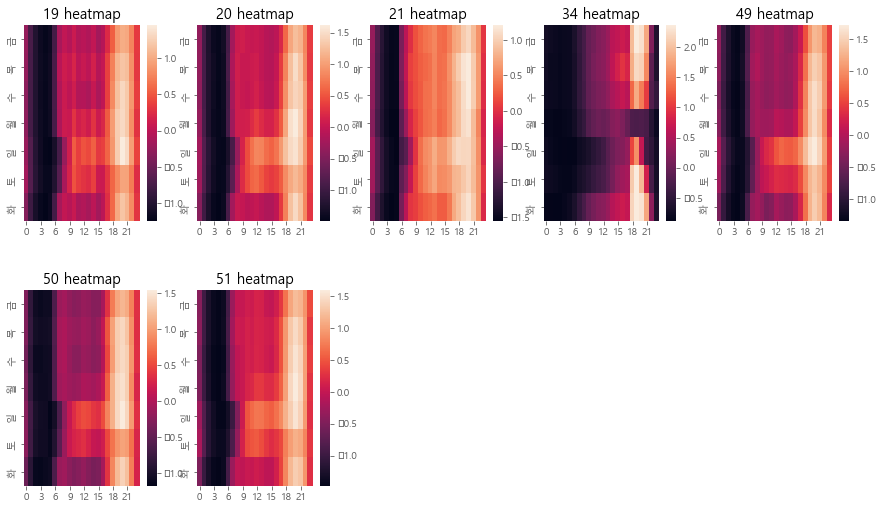

In [150]:
fig = plt.figure(figsize=(15, np.ceil(len(train_1)/5)*4))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35) #서브플롯 간 간격 조정

for i, n in enumerate(t_2):
    plt.subplot(np.ceil(len(t_2)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.건물번호 == n].groupby(['요일', '시간'])['전력사용량'].mean().unstack())
    plt.xlabel('')
    plt.ylabel('')

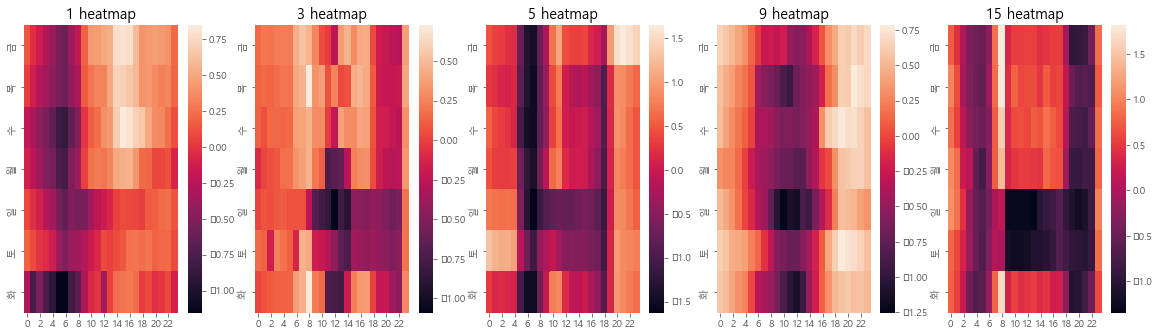

In [24]:
fig = plt.figure(figsize=(20, 5))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35) #서브플롯 간 간격 조정

for i, n in enumerate(t_3):
    plt.subplot(np.ceil(len(t_3)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.건물번호 == n].groupby(['요일', '시간'])['전력사용량'].mean().unstack())
    plt.xlabel('')
    plt.ylabel('')

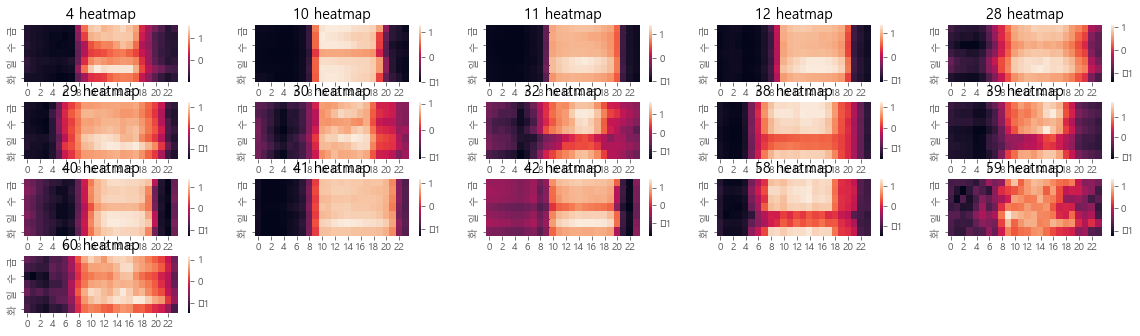

In [20]:
fig = plt.figure(figsize=(20,5))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35) #서브플롯 간 간격 조정

for i, n in enumerate(t_4):
    plt.subplot(np.ceil(len(t_4)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.건물번호 == n].groupby(['요일', '시간'])['전력사용량'].mean().unstack())
    plt.xlabel('')
    plt.ylabel('')

#### 별 차이가 없는듯 하다. 다만, 실제 히트맵 상에서는 4번 군집을 이용하는 것이 더 효율적일 것 같음

### 기상조건에 따른 군집별 영향력 확인

In [134]:
train.columns

Index(['건물번호', '클러스터4', '클러스터', 'date_time', '전력사용량', '기온', '풍속', '습도', '강수량',
       '일조', '비전기냉방설비운영', '태양광보유', '연도', '월', '일', '시간', '요일', '주말', '체감온도',
       '불쾌지수'],
      dtype='object')

In [252]:
from scipy.stats import pearsonr

corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.건물번호 == i].기온,
                       train.loc[train.건물번호 == i].전력사용량)
    corrs.append(corr)

In [253]:
corrs_temp = train.groupby(['클러스터4', '건물번호'])['전력사용량'].mean().to_frame()
temp = train.groupby(['건물번호'])['비전기냉방설비운영', '태양광보유'].max()

In [254]:
# 건물별로, 기상요인별로 상관계수를 계산해줍니다.
corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.건물번호 == i].기온,
                       train.loc[train.건물번호 == i].전력사용량)
    corrs.append(corr)
temp['temp_corr'] = corrs

corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.건물번호 == i].습도,
                       train.loc[train.건물번호 == i].전력사용량)
    corrs.append(corr)
temp['humid_corr'] = corrs

corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.건물번호 == i].일조,
                       train.loc[train.건물번호 == i].전력사용량)
    corrs.append(corr)
temp['sunny_corr'] = corrs

corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.건물번호 == i].풍속,
                       train.loc[train.건물번호 == i].전력사용량)
    corrs.append(corr)
temp['wind_corr'] = corrs

In [255]:
corrs_cl_temp = pd.merge(corrs_temp, temp, how='left', on='건물번호').set_index(corrs_temp.index).round(2)

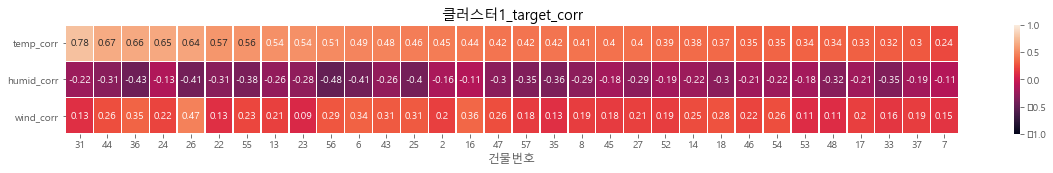

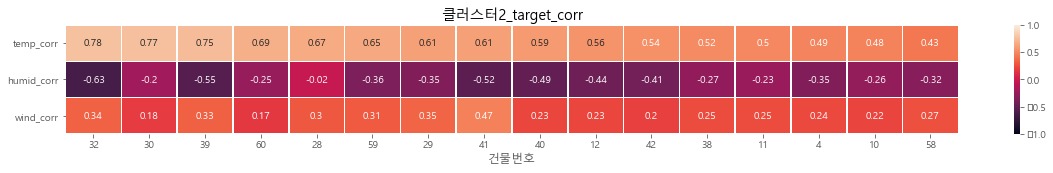

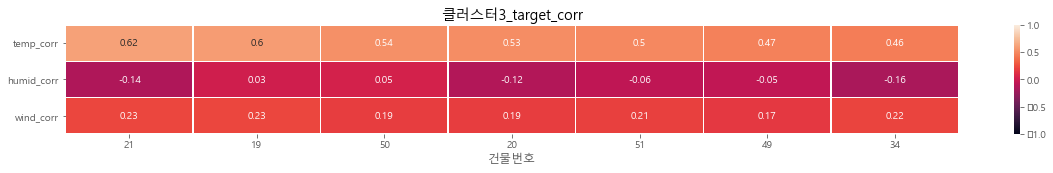

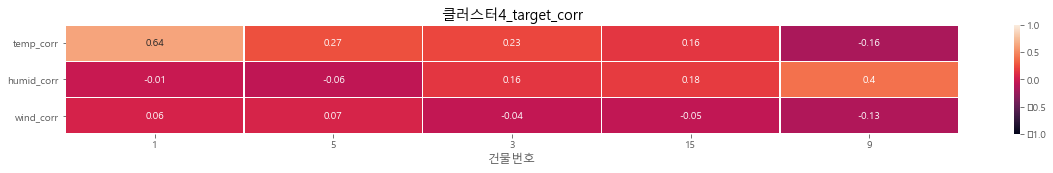

In [257]:
corrs_temp_temp = (corrs_cl_temp[['temp_corr', 'humid_corr', 'wind_corr']]
                   .reset_index()
                   .sort_values(by=['temp_corr', 'humid_corr', 'wind_corr'], ascending=False)
                  .set_index(['건물번호'], drop=False))

plt.figure(figsize=(20, 2))
plt.title('클러스터1_target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.클러스터4 == 1][['temp_corr','humid_corr', 'wind_corr']].T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(20, 2))
plt.title('클러스터2_target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.클러스터4 == 2][['temp_corr', 'humid_corr', 'wind_corr']].T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(20, 2))
plt.title('클러스터3_target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.클러스터4 == 3][['temp_corr', 'humid_corr', 'wind_corr']].T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(20, 2))
plt.title('클러스터4_target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.클러스터4 == 4][['temp_corr', 'humid_corr', 'wind_corr']].T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

- 온도와 전력사용량과의 상관관계: 모든 클러스터에 걸쳐 비교적 높은 상관을 가지고 있음 
- 습도는 음의상관관계를 가짐
- 바람과는 큰 상관이 없는 것으로 보임

#### 위 결과에서, 각 클러스터 간 상관에 차이가 없어보이는 것은 클러스터링에 위 변수들을 사용하지 않았기 떄문임
#### 각 건물의 시간대별 평균 온도, 습도, 풍속을 바탕으로 새롭게 클러스터링을 하자? -> 풍속이 주기성을 띄나?

### 태양광과 전기머시기는 전력사용량과 상관이 있을까

In [258]:
cs_temp = train.groupby(['클러스터4', '건물번호']).max().reset_index().groupby(['클러스터4'])['비전기냉방설비운영', '태양광보유'].sum()
double_temp = train[['클러스터4', '건물번호', '비전기냉방설비운영', '태양광보유']].drop_duplicates().set_index('건물번호')
double_temp['double'] = double_temp.태양광보유 + double_temp.비전기냉방설비운영

In [259]:
cs_temp['double'] = double_temp.loc[double_temp.double == 2].클러스터4.value_counts()

In [260]:
cs_temp['buildings'] = train.groupby(['클러스터4'])['건물번호'].count()/2040

cs_temp['cooler_rate'] = cs_temp.태양광보유 / cs_temp.buildings
cs_temp['solar_rate'] = cs_temp.비전기냉방설비운영 / cs_temp.buildings
cs_temp['double_rate'] = cs_temp.double / cs_temp.buildings

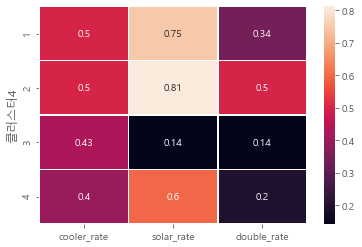

In [261]:
sns.heatmap(cs_temp[['cooler_rate', 'solar_rate', 'double_rate']],
           annot=True, linewidths=.5)

plt.show()

- 군집1: 둘다 높은 상관
- 군집2: 둘다 높은 상관
- 군집3: 태양광은 낮은 상관
- 군집4: 중간...?

In [163]:
train.columns

Index(['건물번호', '클러스터4', '클러스터', 'date_time', '전력사용량', '기온', '풍속', '습도', '강수량',
       '일조', '비전기냉방설비운영', '태양광보유', '연도', '월', '일', '시간', '요일', '주말', '체감온도',
       '불쾌지수'],
      dtype='object')

In [262]:
on = train.loc[(train.비전기냉방설비운영==0)&(train.태양광보유==0)]
off = train.loc[(train.태양광보유==1)&(train.태양광보유==1)]

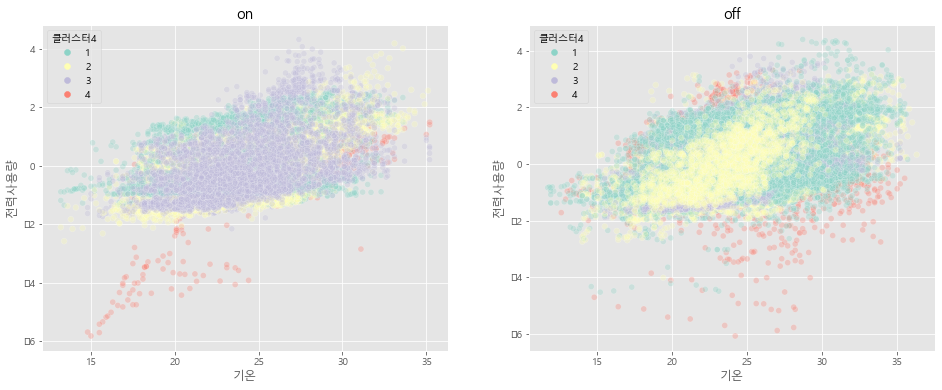

In [267]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.title("on")
sns.scatterplot(data=on, x='기온', y='전력사용량',hue='클러스터4',alpha=0.3,palette='Set3')

plt.subplot(1, 2, 2)
plt.title("off")
sns.scatterplot(data=off, x='기온', y='전력사용량',hue='클러스터4',alpha=0.3,palette='Set3')

plt.show()

#### 해당 클러스터 간에 태양광과 전기머시기의 모유여부와는 큰 상관이 없는 듯 하다

### 해야 할 일
#### 1. 요일과 시간 변수를 이용해 클러스터를 생성함 -> 3개 or 4개 중 몇 개의 군집을 사용할까?
#### 2. 클러스터별로 모델링 vs 클러스터를 변수로 넣고 모델링

In [79]:
train.to_csv('train_cl.csv',encoding='euc-kr',index=False)

### 표준화 이전의 전력사용량을 넣어주기

In [123]:
new = pd.read_csv("D:/전력예측/전처리train.csv", encoding='euc-kr')

In [124]:
train['target'] = new['전력사용량']

In [109]:
train

,건물번호,클러스터4,클러스터,date_time,전력사용량,기온,풍속,습도,강수량,일조,...,태양광보유,연도,월,일,시간,요일,주말,체감온도,불쾌지수,target
0,1,3,3,2020-06-01 00:00:00,-2.795969,17.6,2.5,92.0,0.8,0.0,...,0.0,2020,6,1,0,월,0,18.973374,347.964,8179.056
1,1,3,3,2020-06-01 01:00:00,-3.129259,17.7,2.9,91.0,0.3,0.0,...,0.0,2020,6,1,1,월,0,18.960338,353.930,8135.640
2,1,3,3,2020-06-01 02:00:00,-3.348135,17.5,3.2,91.0,0.0,0.0,...,0.0,2020,6,1,2,월,0,18.658598,335.750,8107.128
3,1,3,3,2020-06-01 03:00:00,-3.795838,17.1,3.2,91.0,0.0,0.0,...,0.0,2020,6,1,3,월,0,18.218957,299.390,8048.808
4,1,3,3,2020-06-01 04:00:00,-3.835633,17.0,3.3,92.0,0.0,0.0,...,0.0,2020,6,1,4,월,0,18.081523,292.830,8043.624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,4,2,2020-08-24 19:00:00,1.840746,27.8,2.3,68.0,0.0,0.7,...,1.0,2020,8,24,19,월,0,30.000891,967.914,4114.368
122396,60,4,2,2020-08-24 20:00:00,1.504699,27.3,1.2,71.0,0.0,0.0,...,1.0,2020,8,24,20,월,0,29.525251,972.030,3975.696
122397,60,4,2,2020-08-24 21:00:00,0.526918,27.3,1.8,71.0,0.0,0.0,...,1.0,2020,8,24,21,월,0,29.487603,972.030,3572.208
122398,60,4,2,2020-08-24 22:00:00,-0.134708,27.1,1.8,74.0,0.0,0.0,...,1.0,2020,8,24,22,월,0,29.276183,995.397,3299.184


In [110]:
train.to_csv('train_cluster.csv',encoding='euc-kr',index=False)

In [85]:
train_1 = train[train['클러스터4']==1]
train_2 = train[train['클러스터4']==2]
train_3 = train[train['클러스터4']==3]
train_4 = train[train['클러스터4']==4]

In [86]:
for i, train in enumerate([train_1, train_2, train_3, train_4]):
    print(f"train_{i+1}의 행개수: {train.shape[0]}, train_{i+1}의 건물개수: {len(train['건물번호'].unique())}")

train_1의 행개수: 65280, train_1의 건물개수: 32
train_2의 행개수: 14280, train_2의 건물개수: 7
train_3의 행개수: 10200, train_3의 건물개수: 5
train_4의 행개수: 32640, train_4의 건물개수: 16


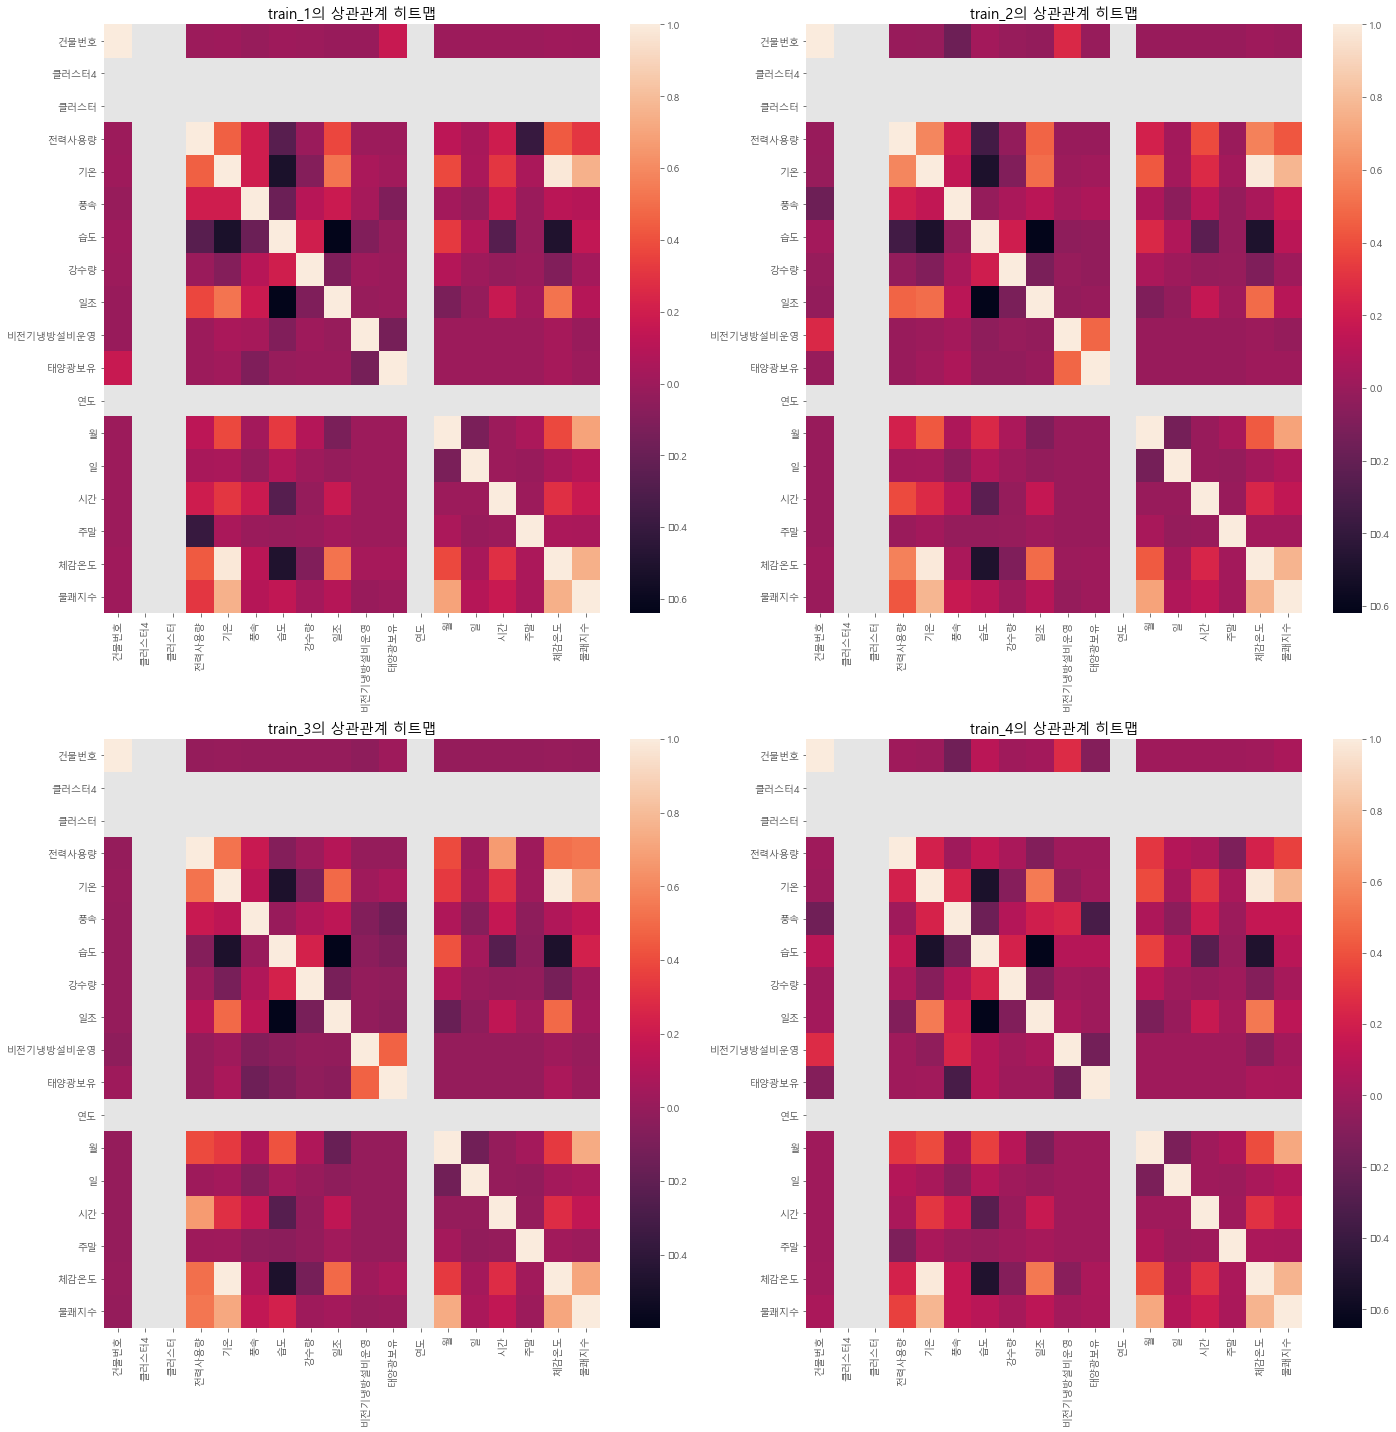

In [299]:
trains = [train_1, train_2, train_3, train_4]

fig, axs = plt.subplots(2, 2,figsize=(20,20))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35) #서브플롯 간 간격 조정

for i, train in enumerate(trains):
    row = i // 2
    col = i % 2
    sns.heatmap(train.corr(), ax=axs[row][col])
    axs[row][col].set_title(f"train_{i+1}의 상관관계 히트맵")

plt.tight_layout()
plt.show()

In [87]:
for i, train in enumerate([train_1, train_2, train_3, train_4]):
    corr_matrix = train.corr()
    corr_with_power = corr_matrix['전력사용량'].sort_values(ascending=False)
    print(f"train_{i+1} 데이터프레임에서 '전력사용량'과 상관관계가 높은 상위 5개의 열과 상관계수:")
    print(corr_with_power[1:6])
    print()

train_1 데이터프레임에서 '전력사용량'과 상관관계가 높은 상위 5개의 열과 상관계수:
기온        0.452815
체감온도      0.434143
일조        0.372269
target    0.324893
불쾌지수      0.311641
Name: 전력사용량, dtype: float64

train_2 데이터프레임에서 '전력사용량'과 상관관계가 높은 상위 5개의 열과 상관계수:
target    0.718440
시간        0.673455
불쾌지수      0.543844
기온        0.527249
체감온도      0.515435
Name: 전력사용량, dtype: float64

train_3 데이터프레임에서 '전력사용량'과 상관관계가 높은 상위 5개의 열과 상관계수:
불쾌지수    0.347143
월       0.308704
체감온도    0.219021
기온      0.208934
습도      0.139952
Name: 전력사용량, dtype: float64

train_4 데이터프레임에서 '전력사용량'과 상관관계가 높은 상위 5개의 열과 상관계수:
기온        0.589870
체감온도      0.571793
일조        0.469879
target    0.428988
불쾌지수      0.427251
Name: 전력사용량, dtype: float64



### 1번 클러스터 회귀 모델링

In [89]:
train_1

,건물번호,클러스터4,클러스터,date_time,전력사용량,기온,풍속,습도,강수량,일조,...,태양광보유,연도,월,일,시간,요일,주말,체감온도,불쾌지수,target
2040,2,1,2,2020-06-01 00:00:00,-0.958833,18.3,2.5,94.0,0.0,0.0,...,0.0,2020,6,1,0,월,0,19.729799,419.921,977.184
2041,2,1,2,2020-06-01 01:00:00,-0.991562,18.8,2.3,89.0,0.0,0.0,...,0.0,2020,6,1,1,월,0,20.330190,445.296,966.168
2042,2,1,2,2020-06-01 02:00:00,-0.971347,19.0,3.2,86.0,0.0,0.0,...,0.0,2020,6,1,2,월,0,20.307253,449.550,972.972
2043,2,1,2,2020-06-01 03:00:00,-0.992524,19.0,4.1,85.0,0.0,0.0,...,0.0,2020,6,1,3,월,0,20.120321,445.040,965.844
2044,2,1,2,2020-06-01 04:00:00,-0.975198,18.9,3.9,87.0,0.0,0.0,...,0.0,2020,6,1,4,월,0,20.047195,445.366,971.676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116275,57,1,2,2020-08-24 19:00:00,0.817937,29.6,2.8,79.0,0.0,0.6,...,0.0,2020,8,24,19,월,0,31.948417,1255.592,3124.224
116276,57,1,2,2020-08-24 20:00:00,0.481950,28.8,3.4,86.0,0.0,0.0,...,0.0,2020,8,24,20,월,0,31.079041,1291.860,2904.768
116277,57,1,2,2020-08-24 21:00:00,0.021623,27.9,1.0,90.0,0.0,0.0,...,0.0,2020,8,24,21,월,0,30.152200,1267.789,2604.096
116278,57,1,2,2020-08-24 22:00:00,-0.283940,27.8,1.7,89.0,0.0,0.0,...,0.0,2020,8,24,22,월,0,30.019626,1245.576,2404.512


In [169]:
new_train1.drop(columns=['일','요일','월'],inplace=True)

In [170]:
new_train1['주간그룹'] = None
new_train1['야간그룹'] = None

new_train1['주간그룹'] = (new_train1['시간'] >= 7) & (new_train1['시간'] <= 18)
new_train1['주간그룹'] = new_train1['주간그룹'].astype(int)

new_train1['야간그룹'] = (new_train1['시간'] < 7) | (new_train1['시간'] > 18)
new_train1['야간그룹'] = new_train1['야간그룹'].astype(int)

In [173]:
new_train1.drop(columns=['전력사용량','시간'],inplace=True) 

In [174]:
new_train1

,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유,주말,체감온도,불쾌지수,target,주간그룹,야간그룹
36720,18.3,2.5,94.0,0.0,0.0,0.0,0.0,0,19.729799,419.921,640.062,0,1
36721,18.8,2.3,89.0,0.0,0.0,0.0,0.0,0,20.330190,445.296,540.270,0,1
36722,19.0,3.2,86.0,0.0,0.0,0.0,0.0,0,20.307253,449.550,494.262,0,1
36723,19.0,4.1,85.0,0.0,0.0,0.0,0.0,0,20.120321,445.040,471.906,0,1
36724,18.9,3.9,87.0,0.0,0.0,0.0,0.0,0,20.047195,445.366,472.878,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
104035,29.4,3.4,66.0,0.0,0.2,0.0,1.0,0,31.741296,1047.310,2909.358,0,1
104036,28.7,1.9,69.0,0.0,0.0,0.0,1.0,0,30.967633,1043.344,2934.954,0,1
104037,28.3,1.1,71.0,0.0,0.0,0.0,1.0,0,30.557110,1043.130,2780.406,0,1
104038,28.3,2.4,72.0,0.0,0.0,0.0,1.0,0,30.536989,1056.847,2529.468,0,1


### 월, 일, 시간, 요일 column 제거
- 요일 변수: 1번 클러스터의 히트맵을 봤을 때, 요일별로 큰 영향이 없고, 주말 변수에 따라 영향을 끼쳐 주말변수만 살려놓음
- 시간 변수: 1번 클러스터의 히트맵을 봤을 때, 7~18시 구간에 많은 사용, 나머지 구간에 적어서 두 개의 변수를 원핫인코딩
- 월, 일 변수: 시계열에 따른 주기성은 다른 연속형 변수에 의해 작용한다고 판단

### 해야 할 것 
- 비전기냉방설비운영, 태양광보유, 주말 변수 원핫인코딩 
- 모든 변수의 산점도 및 상관관계 파악하여 대략적으로 선택할 변수 차출
- 모든 변수를 사용할 때, 회귀모델의 성능 파악 -> 피드백

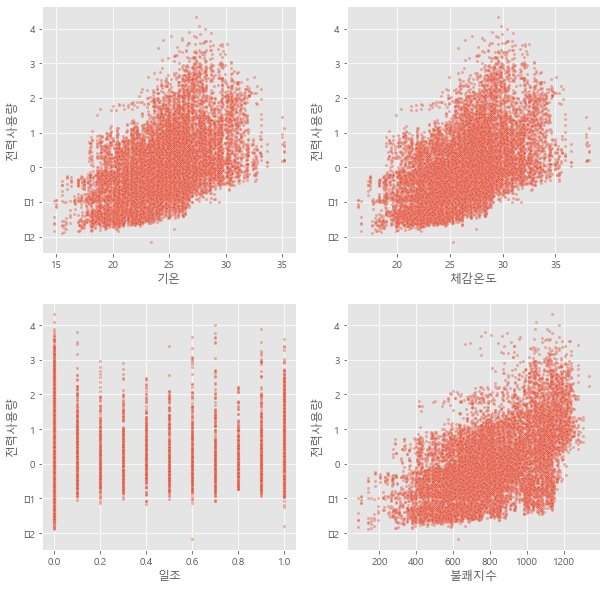

In [82]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
sns.scatterplot(x='기온',y='전력사용량',data=train1,alpha=0.4,s=10)

plt.subplot(2,2,2)
sns.scatterplot(x='체감온도',y='전력사용량',data=train1,alpha=0.4,s=10)

plt.subplot(2,2,3)
sns.scatterplot(x='일조',y='전력사용량',data=train1,alpha=0.4,s=10)

plt.subplot(2,2,4)
sns.scatterplot(x='불쾌지수',y='전력사용량',data=train1,alpha=0.4,s=10)
plt.show()